In [1]:
import logging

import torch
import torch.optim as optim

from robustbench.data import load_cifar10c
from robustbench.model_zoo.enums import ThreatModel
from robustbench.utils import load_model
from nets import *

import time
import tent
import norm
import oracle
from utils import *
from matplotlib import pyplot as plt


import ipdb

from conf import cfg, load_cfg_fom_args, merge_from_file

corruption_list = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness',
                        'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']


In [2]:
logger = logging.getLogger(__name__)
#TODO: build multistage.yaml
merge_from_file('cfgs/multistage.yaml')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(cfg)

BN:
  EPS: 1e-05
  MOM: 0.1
CKPT_DIR: ./ckpt
CORRUPTION:
  DATASET: cifar10
  NUM_EX: 10000
  SEVERITY: [5]
  TYPE: ['gaussian_noise']
CUDNN:
  BENCHMARK: True
DATA_DIR: /gallery_tate/wonjae.roh
DESC: 
EPOCH: 50
EXPERIMENTAL:
  LINEAR_RETRAIN: False
ITERATION: 1
LOG_DEST: log.txt
LOG_TIME: 
MODEL:
  ADAPTATION: pl
  ARCH: Hendrycks2020AugMix_WRN
  EPISODIC: False
OPTIM:
  BETA: 0.9
  DAMPENING: 0.0
  LR: 0.001
  METHOD: Adam
  MOMENTUM: 0.9
  NESTEROV: True
  STEPS: 1
  WD: 0.0
RNG_SEED: 1
SAVE_DIR: ./output
TEST:
  BATCH_SIZE: 200


### adaptation 없이 initial high_entropy samples, low_entropy samples index 찾기

In [3]:
def setup_tent(model):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    model = tent.configure_model(model)
    params, param_names = tent.collect_params(model)
    optimizer = setup_optimizer(params)
    tent_model = tent.Tent(model, optimizer,
                           steps=cfg.OPTIM.STEPS,
                           episodic=cfg.MODEL.EPISODIC)
    logger.info(f"model for adaptation: %s", model)
    logger.info(f"params for adaptation: %s", param_names)
    logger.info(f"optimizer for adaptation: %s", optimizer)
    return tent_model

def setup_pl(model):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    model = tent.configure_model(model)
    params, param_names = tent.collect_params(model)
    optimizer = setup_optimizer(params)
    pl_model = tent.PL(model, optimizer,
                           steps=cfg.OPTIM.STEPS,
                           episodic=cfg.MODEL.EPISODIC)
    logger.info(f"model for adaptation: %s", model)
    logger.info(f"params for adaptation: %s", param_names)
    logger.info(f"optimizer for adaptation: %s", optimizer)
    return pl_model

def setup_optimizer(params):
    """Set up optimizer for tent adaptation.

    Tent needs an optimizer for test-time entropy minimization.
    In principle, tent could make use of any gradient optimizer.
    In practice, we advise choosing Adam or SGD+momentum.
    For optimization settings, we advise to use the settings from the end of
    trainig, if known, or start with a low learning rate (like 0.001) if not.

    For best results, try tuning the learning rate and batch size.
    """
    if cfg.OPTIM.METHOD == 'Adam':
        return optim.Adam(params,
                    lr=cfg.OPTIM.LR,
                    betas=(cfg.OPTIM.BETA, 0.999),
                    weight_decay=cfg.OPTIM.WD)
    elif cfg.OPTIM.METHOD == 'SGD':
        return optim.SGD(params,
                   lr=cfg.OPTIM.LR,
                   momentum=cfg.OPTIM.MOMENTUM,
                   dampening=cfg.OPTIM.DAMPENING,
                   weight_decay=cfg.OPTIM.WD,
                   nesterov=cfg.OPTIM.NESTEROV)
    else:
        raise NotImplementedError
    
def setup_source(model):
    """Set up the baseline source model without adaptation."""
    model.eval()
    logger.info(f"model for evaluation: %s", model)
    return model

In [4]:

# configure model

if cfg.MODEL.ARCH == "Hendrycks2020AugMix_WRN":
    base_model = load_model(cfg.MODEL.ARCH, cfg.CKPT_DIR, cfg.CORRUPTION.DATASET, ThreatModel.corruptions).to(device)
elif cfg.MODEL.ARCH == "RN18":
    base_model = ResNet18(n_classes=10)
    ckpt = torch.load("/home2/wonjae.roh/nprc/tent/ckpt/cifar10/corruptions/ResNet18_pretrained.pth.tar", map_location=device)
    base_model.load_state_dict(ckpt["pretrain-learner"])
else:
    raise NotImplementedError


x_test, y_test = load_cifar10c(cfg.CORRUPTION.NUM_EX, cfg.CORRUPTION.SEVERITY[0], cfg.DATA_DIR, False, cfg.CORRUPTION.TYPE)
x_test, y_test = x_test.to(device), y_test.to(device)

acc, outputs = get_stats(base_model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True)



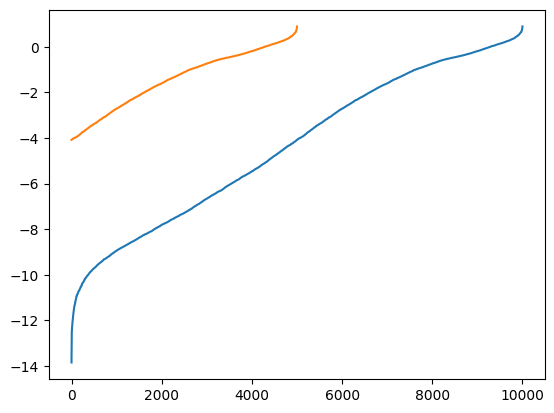

In [5]:
%matplotlib inline

entropy = tent.softmax_entropy(outputs)
entropy = torch.log2(entropy)
entropy_sorted, entropy_sorted_index = entropy.sort()
plt.plot(entropy_sorted.numpy())

high_index = entropy_sorted_index[5000:]
low_index = entropy_sorted_index[:5000]
high_values = entropy[high_index]
low_values = entropy[low_index]
plt.plot(high_values.numpy())

### Correct samples, Wrong samples entropy histogram visualize

                 0
count  7122.000000
mean     -5.281605
std       3.201368
min     -13.851708
25%      -7.943835
50%      -5.617591
75%      -2.451317
max       0.759301
                 0
count  2878.000000
mean     -2.005370
std       2.446358
min     -12.578241
25%      -3.053679
50%      -1.089867
75%      -0.250885
max       0.892242


(array([  1.,   1.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   2.,   1.,   3.,   1.,   3.,   3.,   2.,   4.,   7.,
          3.,   4.,   3.,   7.,   6.,   5.,   8.,   5.,   5.,   7.,   9.,
          4.,  17.,   9.,   8.,  10.,  11.,  10.,  10.,  10.,  11.,   7.,
         12.,  17.,  15.,   8.,  13.,  14.,  19.,  18.,  15.,  12.,  15.,
         15.,  21.,  19.,  20.,  18.,  22.,  23.,  18.,  28.,  23.,  24.,
         21.,  29.,  34.,  20.,  39.,  28.,  29.,  43.,  41.,  36.,  40.,
         63.,  46.,  55.,  53.,  65.,  52.,  68.,  65.,  76.,  94.,  95.,
        115., 154., 136., 140., 113., 130., 135., 121.,  73.,  49.,  23.,
          8.]),
 array([-12.57824135, -12.44353676, -12.30883121, -12.17412663,
        -12.03942204, -11.90471745, -11.7700119 , -11.63530731,
        -11.50060272, -11.36589813, -11.23119259, -11.096488  ,
        -10.96178341, -10.82707882, -10.69237328, -10.55766869,
        -10.4229641 , -10.28825951, -10.15355396, -10.01884937

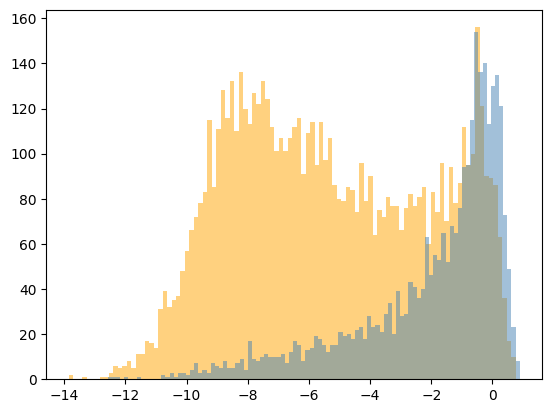

In [6]:
import pandas as pd

data_dir = "/gallery_tate/wonjae.roh/cifar10c"
labels_path = data_dir + '/labels.npy'
labels = np.load(labels_path)
# labels는 10000 sample, 5 severity에 대해 10000개의 같은 label이 5번 반복되는 형태이므로 잘라준다
labels = labels[:10000]

predicted = outputs.argmax(axis=1).numpy()

correct = predicted==labels
wrong = ~correct
entropy_numpy = entropy.numpy()

correct_entropy = entropy_numpy[correct]
wrong_entropy = entropy_numpy[wrong]

correct_describe = pd.DataFrame(correct_entropy)
print(correct_describe.describe())
wrong_describe = pd.DataFrame(wrong_entropy)
print(wrong_describe.describe())

plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [7]:
threshold = entropy_sorted[5000].item()
print(f'threshold : {threshold:.4f}') 

correct_high = np.sum(correct_describe > threshold)
correct_low = np.sum(correct_describe < threshold)
wrong_high = np.sum(wrong_describe > threshold)
wrong_low = np.sum(wrong_describe < threshold)

low_error = 100-float(correct_low * 100 / (correct_low + wrong_low))
high_error = 100-float(correct_high * 100 / (correct_high + wrong_high))
total_error = (low_error + high_error) / 2
                       
print(f'low_error : {low_error:.2f}')
print(f'high_error : {high_error:.2f}') 
print(f'total_error : {total_error:.2f}') 

threshold : -4.0811
low_error : 10.28
high_error : 47.27


### Dataloader (low_entropy, high_entropy, all)

In [8]:
def get_subset(x, y, indices, shuffle=False):
    """get subset of data from indices
    Args:
    x: data
    y: labels
    indices: indices to get subset
    Returns:
    subset of data and labels
    """
    x_sub = x[indices]
    y_sub = y[indices]

    if shuffle:
        rand_idx = np.random.permutation(np.arange(len(x_sub)))
        x_sub, y_sub = x_sub[rand_idx], y_sub[rand_idx]

    return x_sub, y_sub
        
x_low, y_low = get_subset(x_test, y_test, low_index, shuffle=True)
x_high, y_high = get_subset(x_test, y_test, high_index, shuffle=True)     

### adaptation with suitable dataset (all)

In [9]:
def vis_entropy_histogram(outputs, labels):
    entropy = tent.softmax_entropy(outputs)
    entropy = torch.log2(entropy)
    entropy_numpy = entropy.numpy()
    labels = labels.numpy()

    predicted = outputs.argmax(axis=1).numpy()

    correct = predicted==labels
    wrong = ~correct

    correct_entropy = entropy_numpy[correct]
    wrong_entropy = entropy_numpy[wrong]


    correct_describe = pd.DataFrame(correct_entropy)
    print(correct_describe.describe())
    wrong_describe = pd.DataFrame(wrong_entropy)
    print(wrong_describe.describe())

    plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
    plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [10]:
if cfg.MODEL.ADAPTATION == "tent":
    logger.info("test-time adaptation: TENT")
    model = setup_tent(base_model)
elif cfg.MODEL.ADAPTATION == "source":
    logger.info("test-time adaptation: SOURCE")
    model = setup_source(base_model)
elif cfg.MODEL.ADAPTATION == "pl":
    logger.info("test-time adaptation: PL")
    model = setup_pl(base_model)

In [11]:
model.reset()

# check if it only prints desirable updating parameters
check_freeze(model.model)
 

block1.layer.0.bn1.weight
block1.layer.0.bn1.bias
block1.layer.0.bn2.weight
block1.layer.0.bn2.bias
block1.layer.1.bn1.weight
block1.layer.1.bn1.bias
block1.layer.1.bn2.weight
block1.layer.1.bn2.bias
block1.layer.2.bn1.weight
block1.layer.2.bn1.bias
block1.layer.2.bn2.weight
block1.layer.2.bn2.bias
block1.layer.3.bn1.weight
block1.layer.3.bn1.bias
block1.layer.3.bn2.weight
block1.layer.3.bn2.bias
block1.layer.4.bn1.weight
block1.layer.4.bn1.bias
block1.layer.4.bn2.weight
block1.layer.4.bn2.bias
block1.layer.5.bn1.weight
block1.layer.5.bn1.bias
block1.layer.5.bn2.weight
block1.layer.5.bn2.bias
block2.layer.0.bn1.weight
block2.layer.0.bn1.bias
block2.layer.0.bn2.weight
block2.layer.0.bn2.bias
block2.layer.1.bn1.weight
block2.layer.1.bn1.bias
block2.layer.1.bn2.weight
block2.layer.1.bn2.bias
block2.layer.2.bn1.weight
block2.layer.2.bn1.bias
block2.layer.2.bn2.weight
block2.layer.2.bn2.bias
block2.layer.3.bn1.weight
block2.layer.3.bn1.bias
block2.layer.3.bn2.weight
block2.layer.3.bn2.bias


In [12]:
# adapt on low entropy samples
acc_total, outputs_total = get_stats(model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'total_error : {(1-acc_total)*100:.2f}') 

error : 16.95


### adaptation with suitable dataset (low)

In [13]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'low_error : {(1-acc_low)*100:.2f}')  

# without updating, check on high entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'high_error : {(1-acc_high)*100:.2f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total)*100:.2f}') 


low_error : 9.40
high_error : 26.48
total_error : 17.94


                 0
count  4530.000000
mean     -5.038183
std       2.282892
min     -11.288280
25%      -6.698774
50%      -5.395191
75%      -3.600817
max       1.035968
                0
count  470.000000
mean    -0.845923
std      1.543456
min     -7.645236
25%     -1.324355
50%     -0.372278
75%      0.178889
max      1.142151


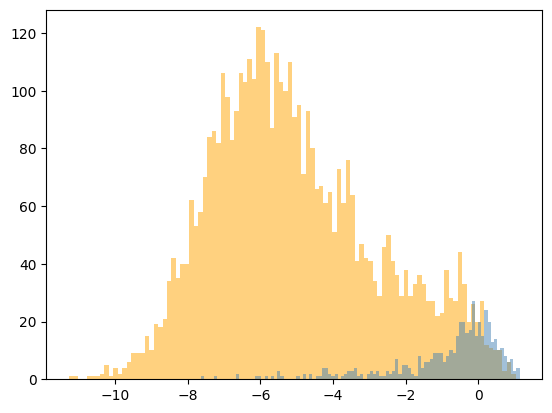

In [14]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  3676.000000
mean     -3.139978
std       2.185225
min     -10.351846
25%      -4.764487
50%      -3.078233
75%      -1.258078
max       0.936269
                 0
count  1324.000000
mean     -0.926871
std       1.392541
min      -7.498244
25%      -1.562769
50%      -0.514150
75%       0.062580
max       0.957947


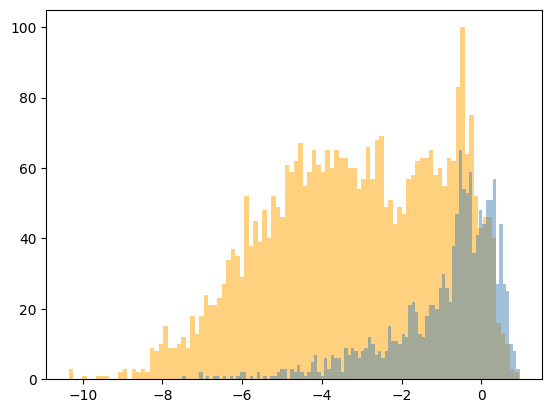

In [15]:
vis_entropy_histogram(outputs_high, y_high)

### adaptation with suitable dataset (high)

In [16]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)

# without updating, check on high entropy samples
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'low_error : {(1-acc_low)*100:.2f}')  
print(f'high_error : {(1-acc_high)*100:.2f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total)*100:.2f}') 

low_error : 8.40
high_error : 27.58
total_error : 17.99


                 0
count  4580.000000
mean     -5.485543
std       2.282147
min     -11.177478
25%      -7.084019
50%      -5.912894
75%      -4.191067
max       0.900061
                0
count  420.000000
mean    -1.133114
std      1.718723
min     -8.049117
25%     -1.734469
50%     -0.553744
75%      0.042294
max      0.872443


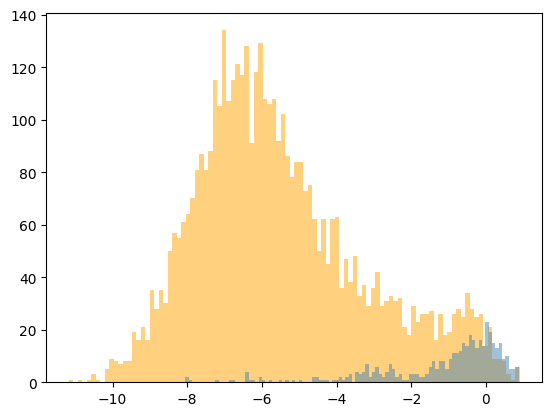

In [17]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  3621.000000
mean     -2.955660
std       2.282662
min     -11.546173
25%      -4.623105
50%      -2.767011
75%      -0.937896
max       1.116703
                 0
count  1379.000000
mean     -0.738659
std       1.290492
min      -6.500287
25%      -1.312269
50%      -0.403732
75%       0.147093
max       1.142134


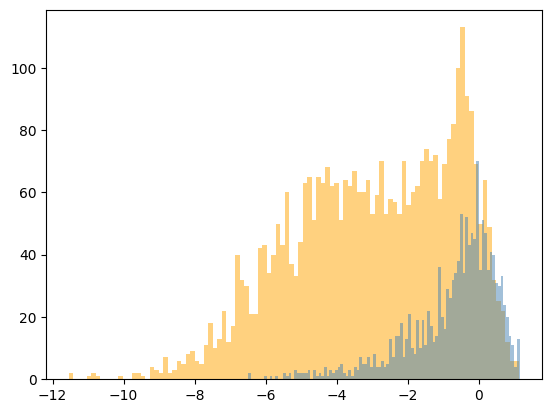

In [18]:
vis_entropy_histogram(outputs_high, y_high)

ResNet18 기준으로는 차이가 좀 나네